In [49]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import zscore
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mysql.connector

In [54]:
def Dataingestion(data_path):

    def readcsv(file, header=True):
        if file.endswith(".json"):
            df = pd.read_json(file)
        elif file.endswith(".csv"):
            df = pd.read_csv(file)
        elif file.endswith(".xlsx"):
            df = pd.read_excel(file)
        else:
            print("Invalid File Format")

        return df

    df = readcsv(file=data_path)

    print(df.isna().sum())
    print("Statistical Properties")
    print(df.describe())
    print("Mean Values")
    mean_values = df.mean(numeric_only=True)
    print(mean_values)

    return df


In [55]:
def outlier_detection(df):

    def detect_outliers(df, columns):
        outliers_dict = {}
        for col in columns:
            q1 = np.percentile(df[col], 25)
            q3 = np.percentile(df[col], 75)
            iqr = q3 - q1
            lower_fence = q1 - (1.5 * iqr)
            upper_fence = q3 + (1.5 * iqr)

            outliers = df[(df[col] < lower_fence) | (df[col] > upper_fence)][col]
            outliers_dict[col] = outliers.tolist()
            return outliers_dict


    outliers_dict = detect_outliers(df, ['Open', 'High', 'Low','Close','Adj Close','Volume'])
    print("Outlier identificaition using Boxplot")
    sns.boxplot(df)
    return outliers_dict




In [6]:
def detect_outliers_zscores(df,columns):
        outliers_dict2 = {}
        for col in columns:
            z_scores = (df[col] - df[col].mean()) / df[col].std()
            outliers = df[np.abs(z_scores) > 3][col]
            outliers_dict2[col] = outliers.tolist()


        return outliers_dict2


In [7]:
def  replace_outliers(df, columns):
    for col in columns:
        q1 = np.percentile(df[col], 25)
        q3 = np.percentile(df[col], 75)
        iqr = q3 - q1
        lower_fence = q1 - (1.5 * iqr)
        upper_fence = q3 + (1.5 * iqr)
        df[col] = np.where((df[col] < lower_fence) | (df[col] > upper_fence), df[col].mean(), df[col])

    return df

# df_cleaned = replace_outliers(x,columns=['Volume'])



In [57]:
def Data_Transformation(df_cleaned):
    df_cleaned['SMA_50'] = df_cleaned['Close'].rolling(window=50).mean()
    period = 50
    alpha = 2 / (period + 1)
    df_cleaned['EMA_50'] = df_cleaned['Close'].ewm(span=period, min_periods=period).mean()
    df_cleaned['RSI'] = 100 - (100 / (1 + (df_cleaned['Close'].diff(1).apply(lambda x: max(0, x)) / df_cleaned['Close'].diff(1).apply(lambda x: abs(x))).rolling(window=14).mean()))
    period = 20
    df_cleaned['MA'] = df_cleaned['Close'].rolling(window=period).mean()
    std_dev = df_cleaned['Close'].rolling(window=period).std()
    df_cleaned['Upper_Band'] = df_cleaned['MA'] + (std_dev * 2)
    df_cleaned['Lower_Band'] = df_cleaned['MA'] - (std_dev * 2)

    figures = []
    

    # Plotting Trend Indicators (SMA and EMA)
    fig1, ax1 = plt.subplots(figsize=(14, 7))
    ax1.plot(df_cleaned['Date'], df_cleaned['Close'], label='Close Price', color='blue')
    ax1.plot(df_cleaned['Date'], df_cleaned['SMA_50'], label='SMA 50', color='red')
    ax1.plot(df_cleaned['Date'], df_cleaned['EMA_50'], label='EMA 50', color='green')
    ax1.legend()
    ax1.set_title('Trend Indicators')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=60))
    plt.xticks(rotation=30)
    figures.append(fig1)

    # Plotting Momentum Indicators (RSI)
    fig2, ax2 = plt.subplots(figsize=(14, 7))
    ax2.plot(df_cleaned['Date'], df_cleaned['RSI'], label='RSI', color='purple')
    ax2.axhline(y=70, color='red', linestyle='--')
    ax2.axhline(y=30, color='green', linestyle='--')
    ax2.legend()
    ax2.set_title('Relative Strength Index (RSI)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('RSI')
    ax2.xaxis.set_major_locator(mdates.DayLocator(interval=60))
    plt.xticks(rotation=30)
    figures.append(fig2)

    # Plotting Bollinger Bands
    fig3, ax3 = plt.subplots(figsize=(14, 7))
    ax3.plot(df_cleaned['Date'], df_cleaned['Close'], label='Close Price', color='blue')
    ax3.plot(df_cleaned['Date'], df_cleaned['Upper_Band'], label='BB Upper', color='green', linestyle='--')
    ax3.plot(df_cleaned['Date'], df_cleaned['Lower_Band'], label='BB Lower', color='green', linestyle='--')
    ax3.fill_between(df_cleaned['Date'], df_cleaned['Lower_Band'], df_cleaned['Upper_Band'], color='lightgray', alpha=0.4)
    ax3.legend()
    ax3.set_title('Bollinger Bands')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Price')
    ax3.xaxis.set_major_locator(mdates.DayLocator(interval=60))
    plt.xticks(rotation=30)
    figures.append(fig3)

    return figures


In [47]:
def resample_dataframe(data):
    data.index = pd.to_datetime(data.index,format="%d-%m-%Y")
    # Resample the data to hourly frequency and forward fill missing values
    hourly_df = data.resample('H').ffill()
    return hourly_df


In [51]:
def database_connect(resample_dataframe):
    

    conn = mysql.connector.connect( 
        host="localhost",
        user="root",
        password="1234",
        database="vyom",
        auth_plugin = "mysql_native_password"

    )

    cur = conn.cursor()
    for row in resample_dataframe.itertuples(index=False):
        cur.execute('''INSERT INTO StockData (Date, Open, High, Low, Close, Adj_Close, Volume)
                        VALUES (%s, %s, %s, %s, %s, %s, %s)''', row)


    conn.commit()

    cur.close()
    conn.close()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Statistical Properties
              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    175.688536   179.621398   171.436469   175.628346   175.628346   
std     105.850697   108.100339   103.294830   105.695101   105.695101   
min      12.073333    12.445333    11.799333    11.931333    11.931333   
25%      55.783333    56.752667    54.126665    54.927666    54.927666   
50%     202.589996   208.000000   198.500000   203.330002   203.330002   
75%     251.334999   256.553330   246.235001   251.769996   251.769996   
max     411.470001   414.496674   405.666656   409.970001   409.970001   

             Volume  
count  1.259000e+03  
mean   1.339133e+08  
std    8.503209e+07  
min    2.940180e+07  
25%    8.122300e+07  
50%    1.095785e+08  
75%    1.572646e+08  
max    9.140820e

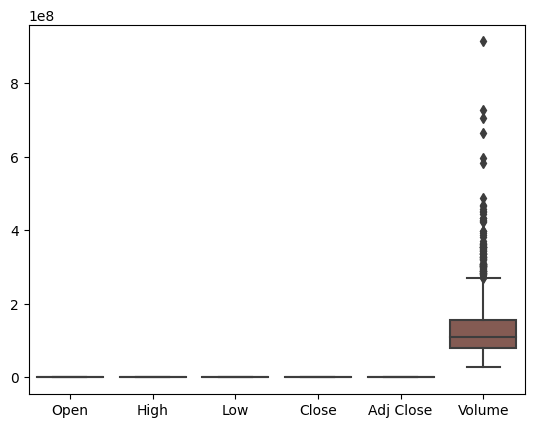

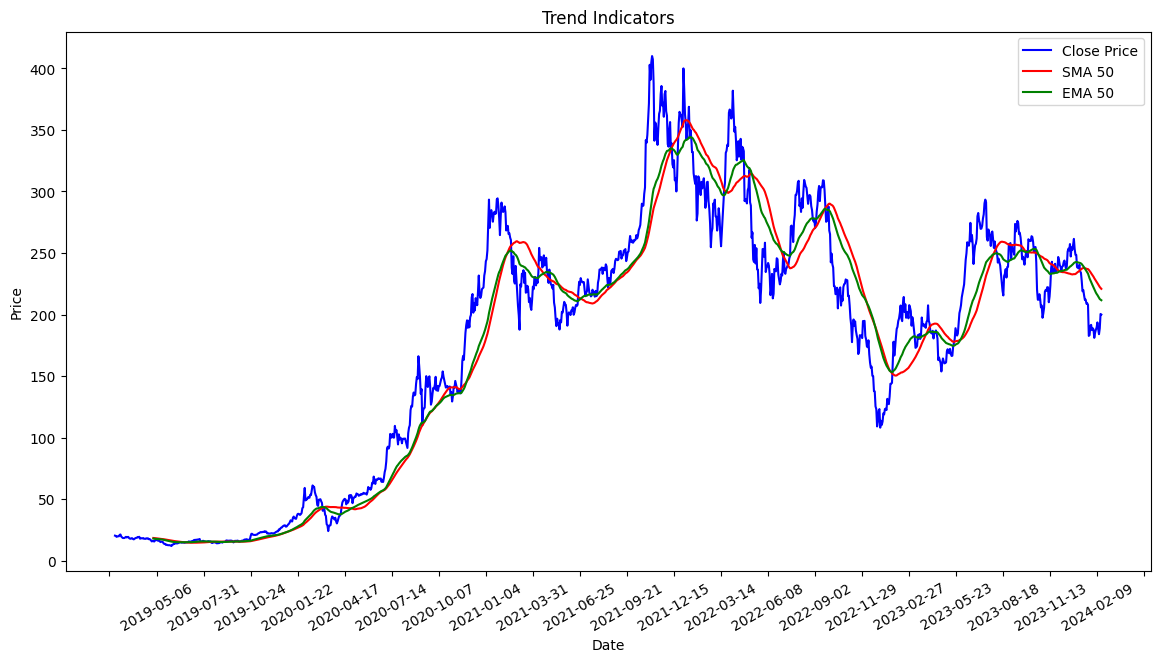

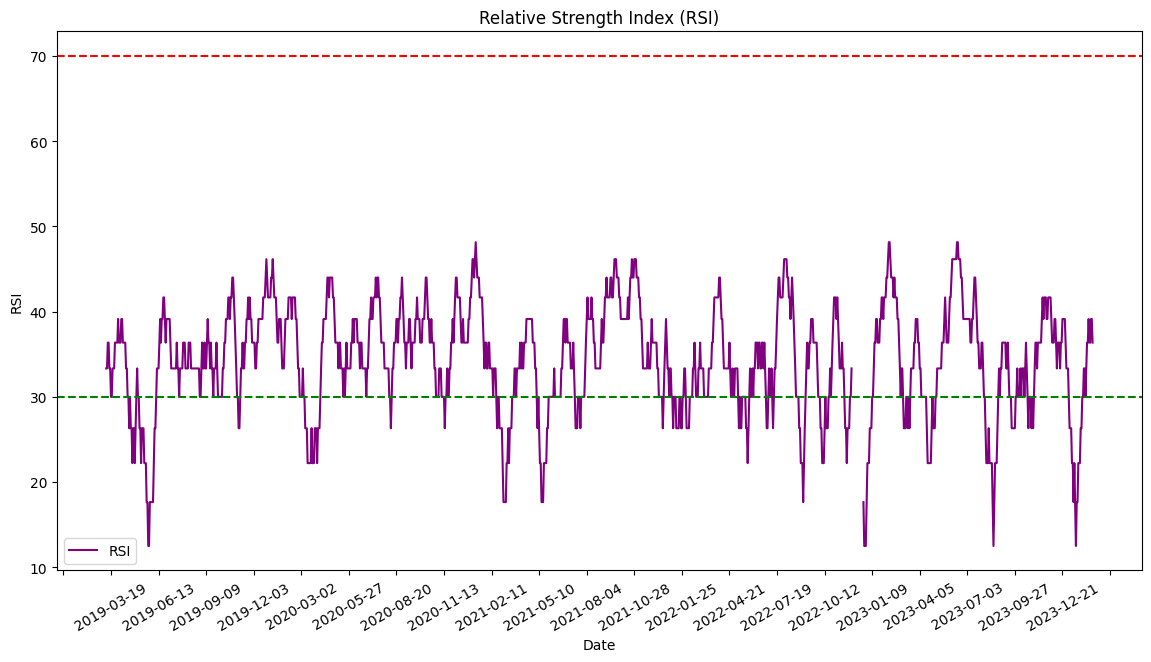

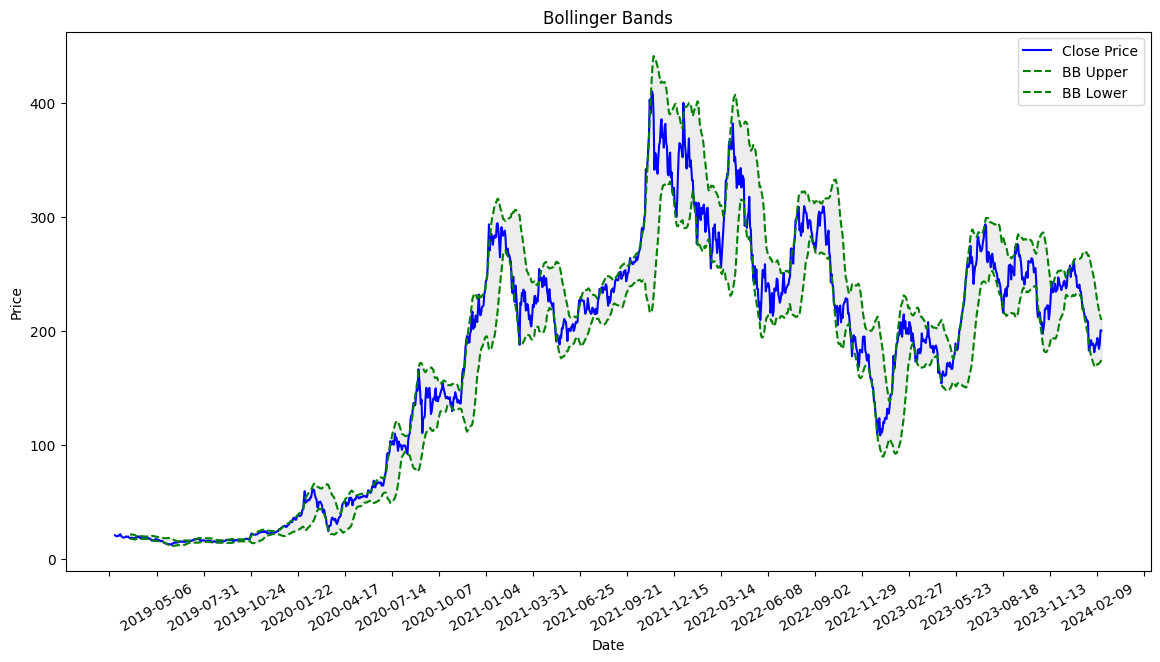

In [58]:
# Your script without unittest.main() call
import logging
import unittest
import pandas as pd

# Import your data processing functions here
# from your_module import Dataingestion, outlier_detection, detect_outliers_zscores, replace_outliers, Data_Transformation

# Configure logging
logging.basicConfig(filename='pipeline.log', level=logging.INFO, format='%(asctime)s:%(levelname)s:%(message)s')

class TestDataProcessing(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        # Initialize the DataFrame and other necessary setup before all tests
        cls.df = Dataingestion(data_path="TSLA.csv")

    def test_readcsv(self):
        # Test the readcsv function to ensure it reads files correctly
        self.assertIsInstance(self.df, pd.DataFrame)
        self.assertFalse(self.df.empty)

    def test_outlier_detection(self):
        # Test the outlier detection functions
        outliers_iqr = outlier_detection(self.df)
        outliers_zscore = detect_outliers_zscores(self.df, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
        columns_with_outliers = list(outliers_zscore.keys())
        self.assertIsInstance(outliers_iqr, dict)
        self.assertIsInstance(outliers_zscore, dict)
        return columns_with_outliers

    def replace_outlier(self):
        columns_with_outliers = self.test_outlier_detection()
        # Test that the replace_outlier function replaces outliers as expected
        df_cleaned = replace_outliers(self.df, columns_with_outliers)
        self.assertEqual(len(df_cleaned), len(self.df))
        return df_cleaned

    def Data_Transformation(self):
        df_cleaned = self.replace_outlier()
        new = Data_Transformation(df_cleaned=df_cleaned)

        self.assertTrue((new['LogRet'] >= 0).all())
        self.assertTrue((new['LogRet'] <= 0).all())
        self.assertIn('SMA50', new.columns)

        

def pipeline():
    try:
        # Step 1: Data Ingestion
        df = Dataingestion(data_path="TSLA.csv")

        # Step 2: Outlier Detection
        outliers = outlier_detection(df)
        # Step 3: Outlier Replacement
        df_cleaned = replace_outliers(df, columns=['Volume'])
        # Step 4: Data Transformation
        
        transformed_data = Data_Transformation(df_cleaned=df_cleaned)
        resampled_data = resample_dataframe(data=df)
        print(resampled_data)
        database_connect(resample_data=resampled_data)

        logging.info("Data processing pipeline completed successfully.")
    except Exception as e:
        logging.error(f"Error in data processing pipeline: {e}", exc_info=True)

# Run the pipeline function
pipeline()
